# **Evaluate the capacity of Wilson and Cowan firing-rate model to simulate the biological sound processing captured by fMRI data with machine learning**

This notebook is part of a group project for the Systems Biology masters at Maastricht University.

You can find more details about my capstone project in this [GitHub repository](https://github.com/sayalaruano/Sound_classif_fmri_and_WCfiring_model).

**Dataset description**

This project encompasses two types of data: experimental (fMRI) and modeling (firing activity) datasets. In relation to the experimental dataset, neural responses were measured across brain regions (voxels), in response to 288 auditory stimuli. This data was collected from a cohort of five subjects. The voxels are distributed within the auditory cortex, including core areas (A1 and R) and belt areas (Slow and Fast). The core and belt areas differ in their spectral and temporal information processing.  

The modeling dataset will be obtained using the computational model proposed by  Zulfiqar et al. (2020). This dataset will consist of the firing rates across time and the tonotopic axis of core and belt areas, with each region represented by its own matrix. These matrices will collectively capture the firing activity for the 288 sounds from the experimental dataset.

## **Imports and data obtention**

In [73]:
# Imports
# Data manipulation and EDA
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Machine learning classifers
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### **Loading experimental and modeling datasets**

In [2]:
# Load modeling dataset 
# model_df = pd.read_csv('modeling_fairingrate_dataset_creation/fr_allsounds.csv', header=None)
X_model = np.genfromtxt('modeling_fairingrate_dataset_creation/fr_allsounds.csv', delimiter=',')
model_df_col_names = pd.read_csv('modeling_fairingrate_dataset_creation/fr_labels.csv', header= None)

# Load experimental dataset
# fmri_df = pd.read_csv('fMRI_dataset_creation/fmri_allsubj_and_regions.csv', header=None)
X_fmri = np.genfromtxt('fMRI_dataset_creation/fmri_allsubj_and_regions.csv', delimiter=',')
fmri_voxel_regions_idx = pd.read_csv('fMRI_dataset_creation/fmri_voxel_regions_idx.csv')

### **Creating target variable**

In [3]:
# Create the target variable vector for both datasets (modeling and experimental)
# 1-48 = "speech", 49-96 = "voice", 97-144 = "animal", 145-192 = "music", 193-240 = "nature", 241-288 = "tool"
categories = {
    range(1, 49): 'speech',
    range(49, 97): 'voice',
    range(97, 145): 'animal',
    range(145, 193): 'music',
    range(193, 241): 'nature',
    range(241, 289): 'tool'
}

y_labels = [value for i in range(1, 289) for key, value in categories.items() if i in key]

y_labels_df = pd.Series(y_labels)

# Encoding the target class label
y = y_labels_df.map({"speech": 0, "voice": 1, "animal": 2, "music": 3, "nature": 4, "tool": 5}).to_numpy()

### **Training-test split**

In [4]:
# Data splitting on test and training for modeling dataset
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(X_model, y, test_size=0.2, random_state =42, stratify=y)

# Data splitting on test and training for experimental dataset
X_train_fmri, X_test_fmri, y_train_fmri, y_test_fmri = train_test_split(X_fmri, y, test_size=0.2, random_state =42, stratify=y)

In [5]:
# Creating a dictionary of the training features matrices for the modeling and experimental datasets
feat_arrays = {'model_df': (X_train_model, y_train_model), 'fmri_df': (X_train_fmri, y_train_fmri)}

## **Exploratory Data Analysis**

### **Modeling dataset**

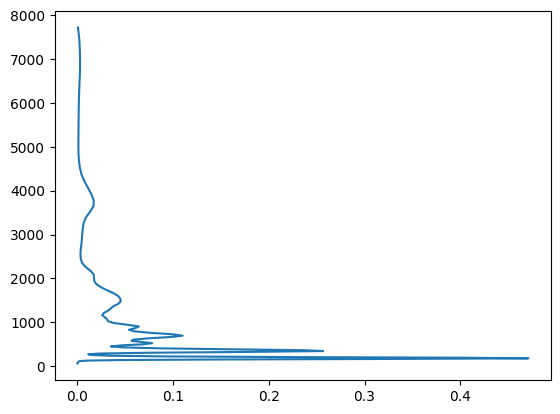

In [ ]:
# Create a line plot of the first sound from the modeling numpy array and its freqeuncy (stores in model_df_col_names df)
#plt.plot(model_df_col_names.iloc[0, :], X_model[0, 0:98])
plt.plot(X_model[0, 0:98], model_df_col_names.iloc[0, :])

#plt.scatter(X_model[0, 0:98], model_df_col_names.iloc[0, :])

#plt.scatter(X_model.iloc[0, 0:98], model_df_col_names.iloc[0, :])

### **Experimental dataset**

### **Target variable**

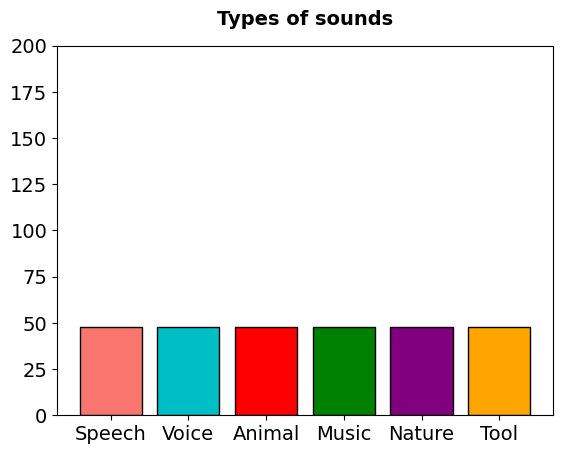

In [ ]:
# Bar plot of active and inactive AMPs
# Data
n_speech = (y_labels_df == "speech").sum()
n_voice = (y_labels_df == "voice").sum()
n_animal = (y_labels_df == "animal").sum()
n_music = (y_labels_df == "music").sum()
n_nat = (y_labels_df == "nature").sum()
n_tool = (y_labels_df == "tool").sum()


x_label = ['Speech', 'Voice', 'Animal', 'Music', 'Nature', 'Tool']
y_label = [n_speech, n_voice, n_animal, n_music, n_nat, n_tool]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x_label, y_label, color = ['#F8766D', '#00BFC4', 'red', 'green', 'purple', 'orange'], ec = 'black')

ax.set_title('Types of sounds', fontsize=14, fontweight='bold', pad=15)

ax.set_ylim(0,200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## **Machine learning models**
First, we create four classification algorithms: random forest, XGBoost, support vector machine, and neural networks. For each algorithm and dataset, a 5-fold cross-validation process will be applied to identify the optimal hyperparameters, ensuring the models are fine-tuned for the classification task. Thne, we choose the best model evaluating some performance metrics (e.g., accuracy, ROC AUC, F1 score, and Matthews Correlation Coefficient) on the test dataset. 

In [6]:
# Dataframe to save performance metrics of the best models
results = pd.DataFrame(columns=['Dataset', 'Model', 'Accuracy_cv', 'Precision_cv', 'Recall_cv', 'F1score_cv', 'Balanced_acc_cv'])

# Dictionary to save the best hyperparameters of the best models
best_params = {}

In [7]:
# Define scoring metrics
f1_mc = make_scorer(f1_score , average='weighted')
prec_mc = make_scorer(precision_score , average='weighted')
recall_mc = make_scorer(recall_score , average='weighted')
bal_acc_mc = make_scorer(balanced_accuracy_score)
acc_mc = make_scorer(accuracy_score)

### **Random forest**

In [8]:
for i, j in feat_arrays.items():
    # Set the grid of parameters of GridSearchCV
    tuned_parameters_rf = [
        {"max_depth": [10, 30, 50, 70, 90, 110, None],
         "max_features": ["auto", "sqrt", "log2"],
         "n_estimators": [50, 100, 500, 800, 1000, 2000]}
    ]

    print(f'# Tuning hyper-parameters Random Forest {i}')
    print()

    # Scoring metrics to be calculated
    scoring = {"Accuracy": acc_mc, "Precision": prec_mc, 
               "Recall": recall_mc, "F1score": f1_mc, 
               "Balanced_accuracy": bal_acc_mc}

    # Create GridSearchCV object with its parameters 
    rf = GridSearchCV(RandomForestClassifier(random_state=10, n_jobs=-1), tuned_parameters_rf, scoring=scoring, 
                      cv=3, refit="Balanced_accuracy", return_train_score=True)
    
    # Train models 
    rf.fit(j[0], j[1])

    # Add best parameters with the name of the model and the dataset to the dictionary
    best_params[f'{i}_rf'] = rf.best_params_
    
    print("Best parameters set found on development set:")
    print(rf.best_params_)
    print(rf.best_score_)

    # Obtain performance metrics of the best model  
    acc_cv = max(rf.cv_results_["mean_test_Accuracy"])

    prec_cv = max(rf.cv_results_["mean_test_Precision"])

    recall_cv = max(rf.cv_results_["mean_test_Recall"])

    f1score_cv = max(rf.cv_results_["mean_test_F1score"])

    bal_acc_cv = max(rf.cv_results_["mean_test_Balanced_accuracy"])

    # Add information to the results dataframe
    new_row = {'Dataset': i, 'Model': 'RandomForest',
               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv,
               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv,
               'Balanced_acc_cv': bal_acc_cv}
    
    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Tuning hyper-parameters Random Forest model_df

Best parameters set found on development set:
{'max_depth': 30, 'max_features': 'log2', 'n_estimators': 1000}
0.551994301994302
# Tuning hyper-parameters Random Forest fmri_df

Best parameters set found on development set:
{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 2000}
0.6695156695156695


### **XGBoost**

In [10]:
for i, j in feat_arrays.items():
    # Set the grid of parameters of GridSearchCV
    tuned_parameters_xvg = [
        {'eta': [0.1, 0.3, 0.5], 
        'max_depth': [5, 10, 20],
        'min_child_weight': [1, 3, 5],
        'objective': ['binary:logistic']}
    ]

    print(f'# Tuning hyper-parameters XGBoost {i}')
    print()

    # Scoring metrics to be calculated
    scoring = {"Accuracy": acc_mc, "Precision": prec_mc, 
               "Recall": recall_mc, "F1score": f1_mc, 
               "Balanced_accuracy": bal_acc_mc}
    
    # Create GridSearchCV object with its parameters 
    xvg = GridSearchCV(XGBClassifier(seed=10, verbosity=1), tuned_parameters_xvg, scoring=scoring, 
                      cv=3, refit="Balanced_accuracy", return_train_score=True, n_jobs=-1)
    
    # Train models 
    xvg.fit(j[0], j[1])

    # Add best parameters with the name of the model and the dataset to the dictionary
    best_params[f'{i}_xvg'] = xvg.best_params_

    print("Best parameters set found on development set:")
    print(xvg.best_params_)
    print(xvg.best_score_)
    
    # Obtain performance metrics of the best model  
    acc_cv = max(xvg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(xvg.cv_results_["mean_test_Precision"])

    recall_cv = max(xvg.cv_results_["mean_test_Recall"])

    f1score_cv = max(xvg.cv_results_["mean_test_F1score"])

    bal_acc_cv = max(xvg.cv_results_["mean_test_Balanced_accuracy"])

    # Add information to the results dataframe
    new_row = {'Dataset': i, 'Model': 'XGBoost',
               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv,
               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv,
               'Balanced_acc_cv': bal_acc_cv}
    
    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Tuning hyper-parameters XGBoost model_df

Best parameters set found on development set:
{'eta': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'objective': 'binary:logistic'}
0.5135327635327634
# Tuning hyper-parameters XGBoost fmri_df

Best parameters set found on development set:
{'eta': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'objective': 'binary:logistic'}
0.6392450142450143


### **Support vector machine**

In [12]:
for i, j in feat_arrays.items():
    # Set the grid of parameters of GridSearchCV
    tuned_parameters_svc = [
        {"C": [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001], 
         "kernel": ["rbf", "linear"]}
    ]

    print(f'# Tuning hyper-parameters Support Vector Machine {i}')
    print()

    # Scoring metrics to be calculated
    scoring = {"Accuracy": acc_mc, "Precision": prec_mc, 
               "Recall": recall_mc, "F1score": f1_mc, 
               "Balanced_accuracy": bal_acc_mc}

    # Create GridSearchCV object with its parameters 
    svc = GridSearchCV(SVC(random_state=10), tuned_parameters_svc, scoring=scoring, 
                      cv=3, refit="Balanced_accuracy", return_train_score=True)
    
    # Train models 
    svc.fit(j[0], j[1])

    # Add best parameters with the name of the model and the dataset to the dictionary
    best_params[f'{i}_svc'] = svc.best_params_

    print("Best parameters set found on development set:")
    print(svc.best_params_)
    print(svc.best_score_)

    # Obtain performance metrics of the best model  
    acc_cv = max(svc.cv_results_["mean_test_Accuracy"])

    prec_cv = max(svc.cv_results_["mean_test_Precision"])

    recall_cv = max(svc.cv_results_["mean_test_Recall"])

    f1score_cv = max(svc.cv_results_["mean_test_F1score"])

    bal_acc_cv = max(svc.cv_results_["mean_test_Balanced_accuracy"])

    # Add information to the results dataframe
    new_row = {'Dataset': i, 'Model': 'SupportVectorMachine',
               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv,
               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv,
               'Balanced_acc_cv': bal_acc_cv}
    
    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Tuning hyper-parameters Support Vector Machine model_df

Best parameters set found on development set:
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.5224358974358975
# Tuning hyper-parameters Support Vector Machine fmri_df

Best parameters set found on development set:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.6816239316239318


### **Multi-layer Perceptron**

In [14]:
for i, j in feat_arrays.items():
    # Set the grid of parameters of GridSearchCV
    tuned_parameters_mlp = [
        {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive']}
    ]

    print(f'# Tuning hyper-parameters Multi-Layer Perceptron {i}')
    print()

    # Scoring metrics to be calculated
    scoring = {"Accuracy": acc_mc, "Precision": prec_mc, 
               "Recall": recall_mc, "F1score": f1_mc, 
               "Balanced_accuracy": bal_acc_mc}

    # Create GridSearchCV object with its parameters 
    mlp = GridSearchCV(MLPClassifier(max_iter = 5000, random_state = 10, solver = "adam"), tuned_parameters_mlp, scoring=scoring, 
                      cv=3, refit="Balanced_accuracy", return_train_score=True)
    
    # Train models 
    mlp.fit(j[0], j[1])

    # Add best parameters with the name of the model and the dataset to the dictionary
    best_params[f'{i}_mlp'] = mlp.best_params_

    print("Best parameters set found on development set:")
    print(mlp.best_params_)
    print(mlp.best_score_)

    # Obtain performance metrics of the best model  
    acc_cv = max(mlp.cv_results_["mean_test_Accuracy"])

    prec_cv = max(mlp.cv_results_["mean_test_Precision"])

    recall_cv = max(mlp.cv_results_["mean_test_Recall"])

    f1score_cv = max(mlp.cv_results_["mean_test_F1score"])

    bal_acc_cv = max(mlp.cv_results_["mean_test_Balanced_accuracy"])

    # Add information to the results dataframe
    new_row = {'Dataset': i, 'Model': 'MultiLayerPerceptron',
               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv,
               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv,
               'Balanced_acc_cv': bal_acc_cv}
    
    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Tuning hyper-parameters Multi-Layer Perceptron model_df

Best parameters set found on development set:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}
0.48967236467236464
# Tuning hyper-parameters Multi-Layer Perceptron fmri_df

Best parameters set found on development set:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant'}
0.577991452991453


In [16]:
# Order the results dataframe by the balanced accuracy
results = results.sort_values(by=['Balanced_acc_cv'], ascending=False)
results

,Dataset,Model,Accuracy_cv,Precision_cv,Recall_cv,F1score_cv,Balanced_acc_cv
5,fmri_df,SupportVectorMachine,0.68,0.71,0.68,0.69,0.68
1,fmri_df,RandomForest,0.67,0.67,0.67,0.65,0.67
3,fmri_df,XGBoost,0.64,0.63,0.64,0.63,0.64
7,fmri_df,MultiLayerPerceptron,0.58,0.66,0.58,0.55,0.58
0,model_df,RandomForest,0.55,0.56,0.55,0.54,0.55
4,model_df,SupportVectorMachine,0.52,0.53,0.52,0.51,0.52
2,model_df,XGBoost,0.51,0.53,0.51,0.51,0.51
6,model_df,MultiLayerPerceptron,0.49,0.51,0.49,0.48,0.49


In [52]:
# Export the results dataframe to a csv file
results.to_csv('Results/Results_all_models_modeling_fmri_datasets.csv', index=False)

## **Evaluation of the best model on the test dataset**
According to the summary table presented above, the best classfier for the modeling dataset was random forest classfier and for the experimental dataset the support vector machine. Considering that random forest was the second best classifier for the experimental dataset and that we want to compare the performance of the best classifier for each dataset, we will use this algorithm to evaluate the performance on the test dataset for both datasets. We will evaluate the random forest with the best hyperparameters obtained in the cross-validation process of the previous section.

The best hyperparameters for the random forest classifier for the modeling dataset were:
- n_estimators: 1000
- max_depth: 30
- max_features: log2

The best hyperparameters for the random forest classifier for the experimental dataset were:
- n_estimators: 2000
- max_depth: 10
- max_features: auto

In [24]:
# Implementation of the best models
best_rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_fmri = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=2000, max_depth=10, max_features='auto', random_state=10))

# Fit the best models
best_rf_model.fit(X_train_model, y_train_model)
best_rf_fmri.fit(X_train_fmri, y_train_fmri)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_features='auto',
                                        n_estimators=2000, random_state=10))])

### **General performance metrics of the best models**

In [25]:
# Function to calculate performance metrics
def performance_metrics(y, y_pred):
  acc = accuracy_score(y, y_pred)

  bal_acc = balanced_accuracy_score(y, y_pred)

  prec = precision_score(y, y_pred, average = 'weighted')

  recall = recall_score(y, y_pred,  average = 'weighted')

  f1score = f1_score(y, y_pred,  average = 'weighted')

  mcc = matthews_corrcoef(y, y_pred)

  results = [acc, bal_acc, prec, recall, f1score, mcc]

  return results

In [26]:
# Dataset to store performance metrics of test dataset
results_bestmodels_test = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_test.set_index(idxs, inplace=True)

In [27]:
# Predicting values with the best model on test dataset
y_test_pred_model = best_rf_model.predict(X_test_model)
y_test_pred_fmri = best_rf_fmri.predict(X_test_fmri)

# Calculate performance metrics of the modeling dataset
results_bestmodels_test["RandomForest_modelingdataset"] = performance_metrics(y_test_model, y_test_pred_model)

# Calculate performance metrics of the fMRI dataset
results_bestmodels_test["RandomForest_fmridataset"] = performance_metrics(y_test_fmri, y_test_pred_fmri)

In [28]:
# Show the final results
results_bestmodels_test

,RandomForest_modelingdataset,RandomForest_fmridataset
Accuracy,0.62,0.74
Balanced accuracy,0.62,0.75
Precision,0.65,0.75
Recall,0.62,0.74
F1score,0.63,0.73
MCC,0.55,0.69


In [29]:
# Export results as a csv
results_bestmodels_test.to_csv("Results/Results_best_classifiers_modeling_fmri_datasets.csv")

### **Performance metrics for every class**

In [54]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_model = classification_report(y_true=y_test_model, y_pred=y_test_pred_model,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_df = pd.DataFrame(report_per_class_rf_model).transpose()

# Show the results
report_per_class_rf_model_df

,precision,recall,f1-score,support
speech,0.78,0.78,0.78,9.00
voice,0.60,0.67,0.63,9.00
animal,0.50,0.70,0.58,10.00
music,0.40,0.40,0.40,10.00
nature,0.62,0.50,0.56,10.00
tool,1.00,0.70,0.82,10.00
accuracy,0.62,0.62,0.62,0.62
macro avg,0.65,0.62,0.63,58.00
weighted avg,0.65,0.62,0.63,58.00


In [55]:
# Export results as a csv
report_per_class_rf_model_df.to_csv("Results/Performance_perclass_rf_modeldataset.csv")

In [56]:
# Performance metrics per class of the best model on the fMRI dataset
report_per_class_rf_fmri = classification_report(y_true=y_test_fmri, y_pred=y_test_pred_fmri,
                                                target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_fmri_df = pd.DataFrame(report_per_class_rf_fmri).transpose()

# Show the results
report_per_class_rf_fmri_df

,precision,recall,f1-score,support
speech,1.00,0.89,0.94,9.00
voice,0.75,1.00,0.86,9.00
animal,0.67,0.40,0.50,10.00
music,0.89,0.80,0.84,10.00
nature,0.62,0.80,0.70,10.00
tool,0.60,0.60,0.60,10.00
accuracy,0.74,0.74,0.74,0.74
macro avg,0.75,0.75,0.74,58.00
weighted avg,0.75,0.74,0.73,58.00


In [57]:
# Export results as a csv
report_per_class_rf_fmri_df.to_csv("Results/Performance_perclass_rf_fmridataset.csv")

### **Confusion matrices**

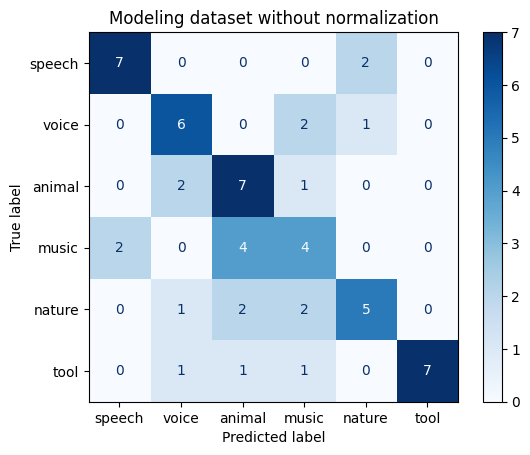

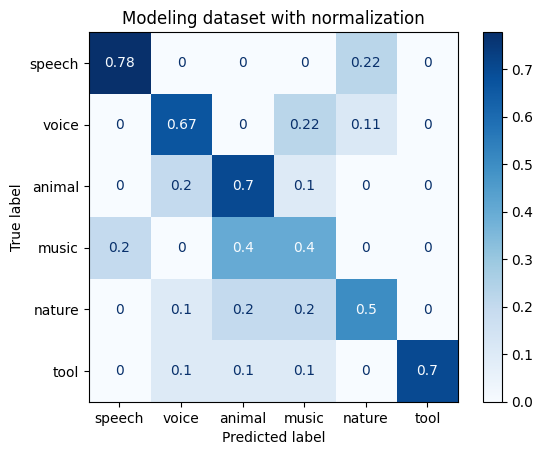

In [66]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization", None),
    ("Modeling dataset with normalization", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_model, X_test_model, y_test_model,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

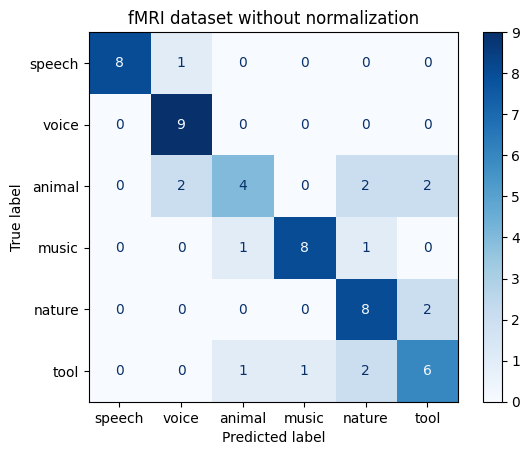

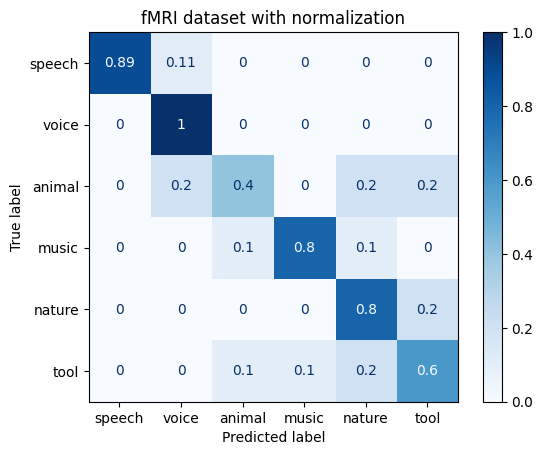

In [67]:
# Create a plot for the confusion matrix of the fmri dataset
titles_options_model = [
    ("fMRI dataset without normalization", None),
    ("fMRI dataset with normalization", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_fmri, X_test_fmri, y_test_fmri,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

### **ROC curves**

In [69]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_model = best_rf_model.predict_proba(X_test_model)
y_score_fmri = best_rf_fmri.predict_proba(X_test_fmri)

# Binarize the outputs
y_test_bin_model = label_binarize(y_test_model, classes=[0, 1, 2, 3, 4, 5])
y_test_bin_fmri = label_binarize(y_test_fmri, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_model.shape[1]

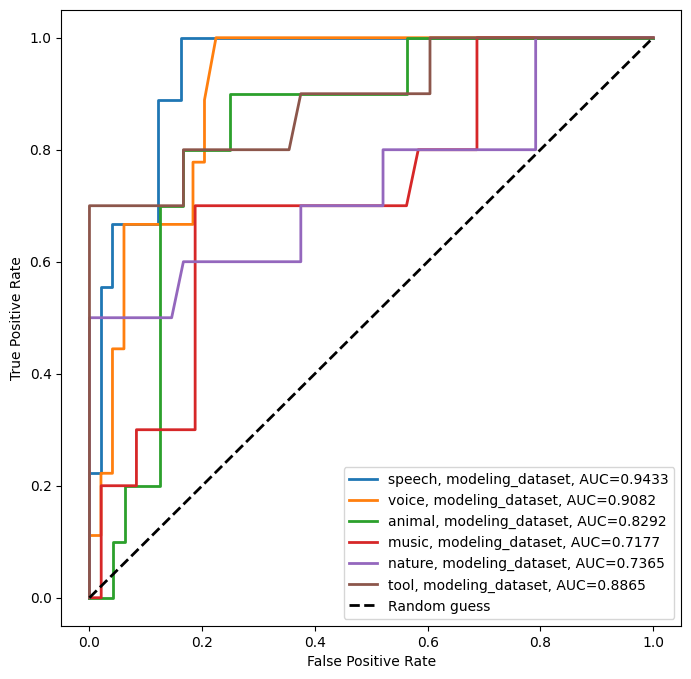

In [71]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_model[:, i], y_score_model[:, i])
  auc = round(roc_auc_score(y_test_bin_model[:, i], y_score_model[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_modelingdataset.png', bbox_inches='tight')

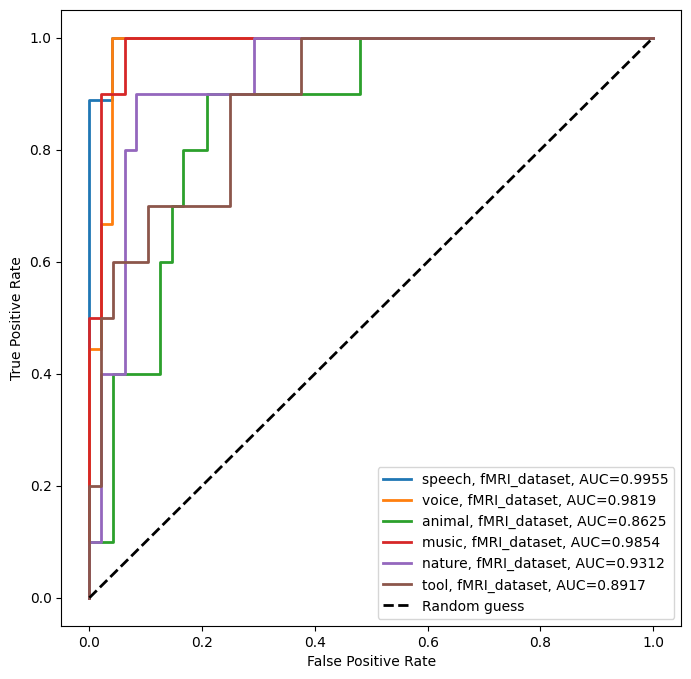

In [72]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_fmri[:, i], y_score_fmri[:, i])
  auc = round(roc_auc_score(y_test_bin_fmri[:, i], y_score_fmri[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", fMRI_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_fmridataset.png', bbox_inches='tight')

### **Save the best models**

In [74]:
# Define the output file's name
output_file_rf_model = f'RandomForest_modelingdataset.bin'
output_file_rf_fmri = f'RandomForest_fmridataset.bin' 

In [75]:
with open(output_file_rf_model, "wb") as f_out1:
    pickle.dump(best_rf_model, f_out1)

In [76]:
with open(output_file_rf_fmri, "wb") as f_out2:
    pickle.dump(best_rf_fmri, f_out2)

## **Feature importance**
...